# Analysis: cross-match to the TNS

TNS = Transient Name Server

## Import packages and retrieve data

In [1]:
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

### Retrieve classified SNe from TNS

At the TNS, search in a generous 10 deg radius near the field centers.

Limit to classified SNe (include FRBs) and select all classification types.

Read in the results from the TNS queries.

In [2]:
tns_cosmos = pd.read_csv('tns_search_cosmos.csv')
tns_elais = pd.read_csv('tns_search_elais.csv')

In [3]:
print(len(tns_cosmos), len(tns_elais))

108 19


In [4]:
tns_cosmos.columns

Index(['ID', 'Name', 'RA', 'DEC', 'Obj. Type', 'Repeater of Primary Burst',
       'DM', 'DM-Err', 'DM-Units', 'Gal. DM Limit', 'Gal. DM Model',
       'Barycentric Datetime', 'Redshift', 'Host Name', 'Host Redshift',
       'Reporting Group/s', 'Discovery Data Source/s', 'Classifying Group/s',
       'Associated Group/s', 'Disc. Internal Name', 'Disc. Instrument/s',
       'Class. Instrument/s', 'TNS AT', 'Public', 'End Prop. Period',
       'Discovery Mag/Flux', 'Discovery Filter', 'Discovery Date (UT)',
       'Sender', 'Remarks', 'Discovery Bibcode', 'Classification Bibcodes',
       'Ext. catalog/s'],
      dtype='object')

Create `coords` columns.

In [5]:
tns_cosmos['coords'] = SkyCoord(tns_cosmos['RA'], tns_cosmos['DEC'], frame='icrs', unit=(u.hourangle, u.deg))
tns_elais['coords'] = SkyCoord(tns_elais['RA'], tns_elais['DEC'], frame='icrs', unit=(u.hourangle, u.deg))

### Retrieve DDF candidates

Read in the candidate coordinates.

In [6]:
fnm = '../all_nightly_epochs_files/candidate_coordinates.dat'
cc_id = np.loadtxt(fnm, dtype='str', usecols=(0))
cc_ra = np.loadtxt(fnm, dtype='float', usecols=(1))
cc_dec = np.loadtxt(fnm, dtype='float', usecols=(2))

In [7]:
cc_coords = SkyCoord(cc_ra, cc_dec, frame='icrs', unit=u.deg)

## Cross-match TNS and DDF objects

Index the COSMOS and ELAIS candidates.

First define the field boundaries (roughly).

In [8]:
c_ra_l = 148
c_ra_h = 152
c_de_l = 0.0
c_de_h = 4.5
e_ra_l = 6.0
e_ra_h = 11.2
e_de_l = -45.5
e_de_h = -41.5

In [9]:
cx = np.where((cc_ra > c_ra_l) & (cc_ra < c_ra_h) & (cc_dec > c_de_l) & (cc_dec < c_de_h))[0]
ex = np.where((cc_ra > e_ra_l) & (cc_ra < e_ra_h) & (cc_dec > e_de_l) & (cc_dec < e_de_h))[0]

### Find TNS candidates within COSMOS/ELAIS

We searched a too-wide region in TNS.

Narrow it down.

Plot overlap for COSMOS, then ELAIS.

1 SN 2023dyl
2 SN 2022adxs
3 SN 2022xil
4 SN 2022and
5 SN 2021adwh
6 SN 2021ghc
7 SN 2021bnv


<bound method Figure.show of <Figure size 300x200 with 1 Axes>>

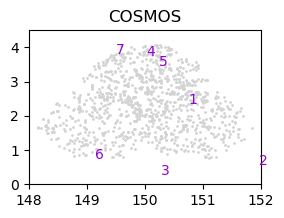

In [10]:
fig = plt.figure(figsize=(3, 2))
plt.plot(cc_ra[cx], cc_dec[cx], '.', ms=2, color='lightgrey')
tmp = 1
for coord, name in zip(tns_cosmos['coords'], tns_cosmos['Name']):
    ra = coord.ra.deg
    dec = coord.dec.deg
    if (ra > c_ra_l) & (ra < c_ra_h) & (dec > c_de_l) & (dec < c_de_h):
        print(tmp, name)
        plt.text(ra, dec, tmp, color='darkviolet')
        tmp += 1
    del ra, dec
plt.xlim([c_ra_l, c_ra_h])
plt.ylim([c_de_l, c_de_h])
plt.title('COSMOS')
fig.show

SN 2023tfc


<bound method Figure.show of <Figure size 300x200 with 1 Axes>>

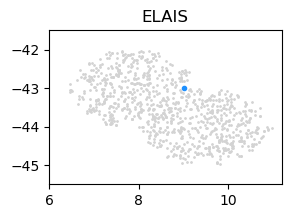

In [11]:
fig = plt.figure(figsize=(3, 2))
plt.plot(cc_ra[ex], cc_dec[ex], '.', ms=2, color='lightgrey')
for coord, name in zip(tns_elais['coords'], tns_elais['Name']):
    ra = coord.ra.deg
    dec = coord.dec.deg
    if (ra > e_ra_l) & (ra < e_ra_h) & (dec > e_de_l) & (dec < e_de_h):
        print(name)
        plt.plot(ra, dec, '.', color='dodgerblue')
    del ra, dec
plt.xlim([e_ra_l, e_ra_h])
plt.ylim([e_de_l, e_de_h])
plt.title('ELAIS')
fig.show

### Identify TNS objects to investigate further

OK so just a few potentials.

In [12]:
tns_c_names = np.asarray(['SN 2023dyl', 'SN 2022adxs', 'SN 2022xil',
                          'SN 2022and', 'SN 2021adwh', 'SN 2021ghc',
                          'SN 2021bnv'], dtype='str')
tns_e_names = np.asarray(['SN 2023tfc'], dtype='str')

#### Proper cross match in COSMOS/ELAIS

In [13]:
for name in tns_c_names:
    tx = np.where(tns_cosmos['Name'] == name)[0]
    coord = tns_cosmos['coords'][tx[0]]
    discd = tns_cosmos['Discovery Date (UT)'][tx[0]]
    discm = tns_cosmos['Discovery Mag/Flux'][tx[0]]
    del tx
    idx, sep2d, sep3d = coord.match_to_catalog_sky(cc_coords)
    print('%15s %25s %6.3f %12s %13.8f' % (name, discd, discm, cc_id[idx], sep2d[0].arcsec))
    del idx, sep2d, sep3d

     SN 2023dyl   2023-03-27 02:49:58.656 18.301    DC23klgla    0.10905249
    SN 2022adxs   2022-12-22 07:23:57.120 19.251      DC21sap 2597.87181147
     SN 2022xil   2022-10-10 12:18:43.200 19.170    DC22eawan 2245.02198543
     SN 2022and   2022-01-27 10:49:26.400 18.965      DC21rcr   38.17160714
    SN 2021adwh   2021-11-03 12:29:46.000 20.439    DC22eathc    0.15902037
     SN 2021ghc   2021-03-19 08:44:09.600 19.669      DC21fwk  682.91179676
     SN 2021bnv   2021-02-03 09:17:16.800 18.570    DC21bwbfe    0.18806831


In [14]:
for name in tns_e_names:
    tx = np.where(tns_elais['Name'] == name)[0]
    coord = tns_elais['coords'][tx[0]]
    discd = tns_elais['Discovery Date (UT)'][tx[0]]
    discm = tns_elais['Discovery Mag/Flux'][tx[0]]
    del tx
    idx, sep2d, sep3d = coord.match_to_catalog_sky(cc_coords)
    print('%15s %25s %6.3f %12s %13.8f' % (name, discd, discm, cc_id[idx], float(sep2d[0].arcsec)))
    del idx, sep2d, sep3d

     SN 2023tfc   2023-09-17 22:01:14.592 19.247    DC21ctnsk  285.25150781


#### Plot to see nearest DDF neighbors

Only three being matched within one arcsec isn't that weird, but, let's see if we can identify whether TNS candidates are near the edge or just out the field boundary or what's happening.

Do lazy no grid.

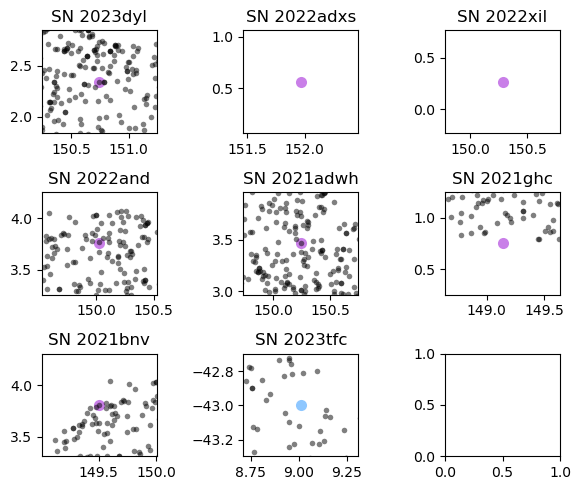

In [15]:
fig, ax = plt.subplots( 3, 3, figsize=(6, 5), sharex=False, sharey=False )

i = 0
j = 0

for name in tns_c_names:
    tx = np.where(tns_cosmos['Name'] == name)[0]
    coord = tns_cosmos['coords'][tx[0]]
    ra = coord.ra.deg
    dec = coord.dec.deg
    
    ax[i, j].plot(ra, dec, 'o', alpha=0.5, ms=8, color='darkviolet', mew=0)
    ax[i, j].plot(cc_ra, cc_dec, 'o', alpha=0.5, ms=4, color='black', mew=0)
    ax[i, j].set_xlim([ra-0.5, ra+0.5])
    ax[i, j].set_ylim([dec-0.5, dec+0.5])
    ax[i, j].set_title(name)
    j += 1
    if j == 3:
        i += 1
        j = 0

for name in tns_e_names:
    tx = np.where(tns_elais['Name'] == name)[0]
    coord = tns_elais['coords'][tx[0]]
    ra = coord.ra.deg
    dec = coord.dec.deg
    
    ax[i, j].plot(ra, dec, 'o', alpha=0.5, ms=8, color='dodgerblue', mew=0)
    ax[i, j].plot(cc_ra, cc_dec, 'o', alpha=0.5, ms=4, color='black', mew=0)
    ax[i, j].set_xlim([ra-0.3, ra+0.3])
    ax[i, j].set_ylim([dec-0.3, dec+0.3])
    ax[i, j].set_title(name)

plt.tight_layout()
plt.show()

In the field, out of the field, or on the edge?

COSMOS:
```
SN 2023dyl   in
SN 2022adxs  out
SN 2022xil   out
SN 2022and   in
SN 2021adwh  in
SN 2021ghc   edge
SN 2021bnv   in
```

ELAIS
```
SN 2023tfc   in
```

So there are five TNS SNe which were in the field, and we should check if we were observing when they were discovered.

### Down-select to 5 in-field TNS objects

Continue with these four in COSMOS.
```
SN 2023dyl   in
SN 2022and   in
SN 2021adwh  in
SN 2021bnv   in
```

And this one in ELAIS.
```
SN 2023tfc   in
```

In [16]:
tns_c_infield = np.asarray(['SN 2023dyl', 'SN 2022and', 'SN 2021adwh', 'SN 2021bnv'], dtype='str')
tns_e_infield = np.asarray(['SN 2023tfc'], dtype='str')

#### Was DDF observing when the TNS objects happened?

Plot the nightly-epoch limiting magnitudes as a function of time.

Overplot the date of discovery for the five TNS objects.

See if we were even observing when they were happening.

Read in the nightly epoch limiting magnitudes.

In [17]:
fnm = '../all_nightly_epochs_files/nightly_epoch_magnitude_limits.dat'
lim_field = np.loadtxt(fnm, dtype='str', usecols=(0))
lim_cdate = np.loadtxt(fnm, dtype='str', usecols=(1))
lim_mjd   = np.loadtxt(fnm, dtype='float', usecols=(2))
lim_filt  = np.loadtxt(fnm, dtype='str', usecols=(3))
lim_mag   = np.loadtxt(fnm, dtype='float', usecols=(5))

Plot the limits as a function of MJD and then overplot the discovery dates.

In [18]:
all_filters = ['g', 'r', 'i']
all_colors = ['green', 'red', 'blue']

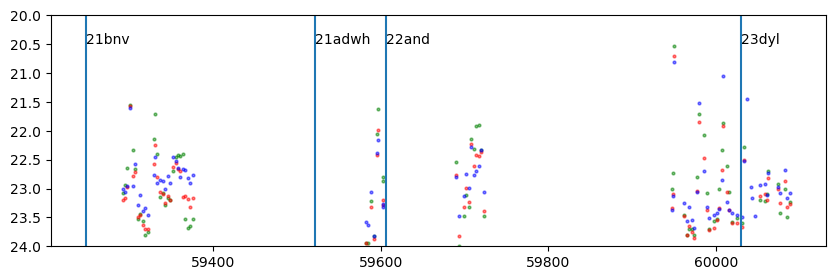

In [19]:
fig = plt.figure(figsize=(10, 3))
for f, filt in enumerate(all_filters):
    fx = np.where((lim_field == 'COSMOS') & (lim_filt == filt))[0]
    plt.plot(lim_mjd[fx], lim_mag[fx], 'o', alpha=0.5, ms=2, color=all_colors[f])
    del fx

for i, name in enumerate(tns_c_infield):
    tx = np.where(tns_cosmos['Name'] == name)[0]
    discd = tns_cosmos['Discovery Date (UT)'][tx[0]]
    tmp = discd.find(' ')
    tmp2 = discd[:tmp]+'T'+discd[tmp+1:]
    time = Time(tmp2, format='isot', scale='utc')
    plt.axvline(time.mjd)
    plt.text(time.mjd, 20.5, name[5:])
    del tx, discd, tmp, tmp2, time

plt.ylim([24.0, 20.0])
fig.show()

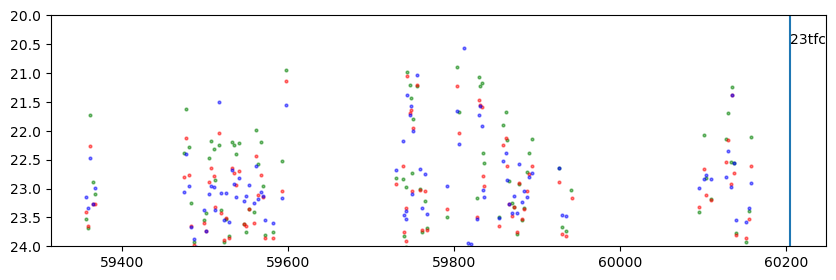

In [20]:
fig = plt.figure(figsize=(10, 3))
for f, filt in enumerate(all_filters):
    fx = np.where((lim_field == 'ELAIS') & (lim_filt == filt))[0]
    plt.plot(lim_mjd[fx], lim_mag[fx], 'o', alpha=0.5, ms=2, color=all_colors[f])
    del fx

for i, name in enumerate(tns_e_infield):
    tx = np.where(tns_elais['Name'] == name)[0]
    discd = tns_elais['Discovery Date (UT)'][tx[0]]
    tmp = discd.find(' ')
    tmp2 = discd[:tmp]+'T'+discd[tmp+1:]
    time = Time(tmp2, format='isot', scale='utc')
    plt.axvline(time.mjd)
    plt.text(time.mjd, 20.5, name[5:])
    del tx, discd, tmp, tmp2, time

plt.ylim([24.0, 20.0])
fig.show()

## Explore SN 20223dyl

https://www.wis-tns.org/object/2023dyl

Alright so SN 2023dyl in COSMOS, DC23klgla, was the only one we could have detected, and did.

### Plot DDF lightcurve

In [21]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'
candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

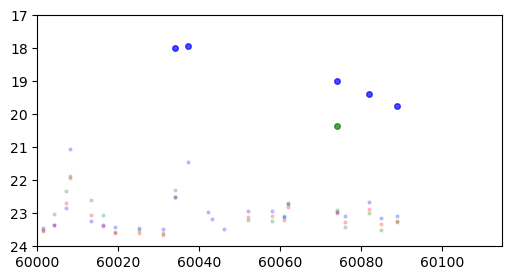

In [22]:
fig = plt.figure(figsize=(6, 3))
for f, filt in enumerate(all_filters):
    fx = np.where((lim_field == 'COSMOS') & (lim_filt == filt))[0]
    plt.plot(lim_mjd[fx], lim_mag[fx], 'o', alpha=0.2, ms=2, color=all_colors[f])
    del fx
    
    fx = np.where((candLC_candid == 'DC23klgla') & (candLC_filter == filt))[0]
    plt.plot(candLC_mjd[fx], candLC_mag[fx], 'o', alpha=0.7, ms=4, color=all_colors[f])
    del fx

plt.ylim([24.0, 17.0])
plt.xlim([60000, 60115])
fig.show()

What happened to this DDF light curve?

DC23klgla

https://decat-webap.lbl.gov/decatview.py/cand/DC23klgla

Reviewing the object light curve, there does seem to be missing photometry, it's not soley a result of the cuts and combination of individual detections into nightly epochs (though that could be part of it).

### Compare with ZTF data from ALeRCE (ZTF23aadwjtg)

From TNS, can see the ZTF name is ZTF23aadwjtg.

https://alerce.online/object/ZTF23aadwjtg

From ALeRCE, can grab the photometry and take a look.

In [23]:
jtg_dets = pd.read_csv('ZTF23aadwjtg_detections.csv')
jtg_nondets = pd.read_csv('ZTF23aadwjtg_nondetections.csv')

In [24]:
jtg_dets.columns

Index(['tid', 'mjd', 'candid', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'distnr', 'magpsf', 'magpsf_corr', 'magpsf_corr_ext', 'magap',
       'magap_corr', 'sigmapsf', 'sigmapsf_corr', 'sigmapsf_corr_ext',
       'sigmagap', 'sigmagap_corr', 'ra', 'dec', 'rb', 'rbversion', 'drb',
       'magapbig', 'sigmagapbig', 'rfid', 'has_stamp', 'corrected', 'dubious',
       'candid_alert', 'step_id_corr', 'phase', 'parent_candid'],
      dtype='object')

From poking around in ALeRCE, figured the `fid` column is filter, and that 1 is g and 2 is r.

In [25]:
# jtg_dets

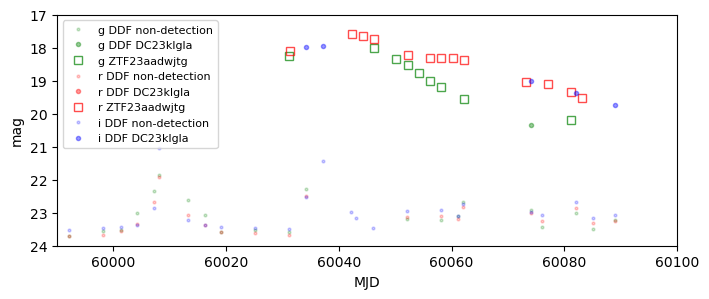

In [26]:
fig = plt.figure(figsize=(8, 3))
for f, filt in enumerate(all_filters):
    fx = np.where((lim_field == 'COSMOS') & (lim_filt == filt))[0]
    plt.plot(lim_mjd[fx], lim_mag[fx], 'o', alpha=0.2, ms=2, color=all_colors[f],
             label=filt + ' DDF non-detection')
    del fx
    
    fx = np.where((candLC_candid == 'DC23klgla') & (candLC_filter == filt))[0]
    plt.plot(candLC_mjd[fx], candLC_mag[fx], 'o', alpha=0.4, ms=3, 
             color=all_colors[f], label=filt + ' DDF DC23klgla')
    del fx
    
    if filt == 'g':
        fx = np.where(jtg_dets['fid'] == 1)[0]
    elif filt == 'r':
        fx = np.where(jtg_dets['fid'] == 2)[0]
    if (filt == 'g') | (filt == 'r'):
        plt.plot(jtg_dets['mjd'][fx], jtg_dets['magpsf'][fx], 's', alpha=0.7, ms=6, 
                 mec=all_colors[f], color='none', label=filt + ' ZTF23aadwjtg')
        del fx

plt.legend(loc='upper left', fontsize=8)
plt.ylim([24.0, 17.0])
plt.xlim([59990, 60100])
plt.xlabel('MJD')
plt.ylabel('mag')
fig.show()

Well this is a mystery, should've been able to detect the full light curve here pretty much.